# AI6101 Reinforcement Learning Assignment

---



**Goh Jun Hao G21202327**







In [ ]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
%matplotlib inline

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [ ]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

# Q-learning Agent

Q-learning is a value-based method that uses a Q-
table to record the estimated Q-values for various
actions in different states. The Q-table is initialized
prior to exploring the environment. As the agent
interacts with the environment, it updates the Q(s,
a) values using the Bellman equation, allowing the
agent to continually learn and improve its under-
standing of the environment. The Q-function continues to be updated until it reaches convergence or
the specified number of iterations

In [ ]:
class QAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_seq = [] # Initialize empty action sequence list
        self.total_action_seq = [] # Initialize empty action sequence list
        self.max_agent_seq = []

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

    def learn(self):
        """Runs Q-learning algorithm to learn optimal policy."""
        rewards_per_episode = []
        start_time = time.time()

        for episode in range(self.num_episodes):
            # Initialize variables for storing state and action sequences
            action_seq = []
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                # Update Q-Table using Q-Learning algorithm
                old_qvalue = self.q_table[state][action]
                next_max = max(self.q_table[next_state].values())
                new_qvalue = (1 - self.alpha) * old_qvalue + self.alpha * (reward + self.gamma * next_max)
                self.q_table[state][action] = new_qvalue

                # Update total reward and current state
                total_reward += reward
                state = next_state
                action_seq.append(action)
                self.action_seq = action_seq # Append action to the action sequence list

            self.total_action_seq.append(action_seq)
            rewards_per_episode.append(total_reward)
            max_reward = max(rewards_per_episode)
            index_max_reward = rewards_per_episode.index(max_reward)
            self.max_action_seq = self.total_action_seq[index_max_reward]

        elapsed_time = time.time() - start_time
        elapsed_time_formatted = str(round(elapsed_time, 2)) + "s"
        #print('Elapsed time:', elapsed_time_formatted)
        #print('Maximum reward =', max_reward)
        #print('Episode of maximum reward achieved =', index_max_reward)
        #print('Action sequence of maximum reward =', self.max_action_seq)
        return rewards_per_episode

# Q-learning Epsilon Parameter Experiment

In Q-learning, the epsilon (ε) parameter governs the balance between exploration and exploitation. Epsilon is a value ranging from 0 to 1, signifying the likelihood of the agent choosing a random action (exploration) rather than opting for the action with the highest Q-value (exploitation).

A larger epsilon value (nearer to 1) implies that the agent will engage in more exploration, frequently selecting random actions. This can aid the agent in uncovering new states and actions that could result in superior long-term rewards. However, excessive exploration may also cause the agent to frequently choose suboptimal actions, negatively impacting overall performance.

On the other hand, a smaller epsilon value (closer to 0) indicates that the agent will primarily exploit its existing knowledge by selecting the action with the highest Q-value. While this can yield improved short-term rewards, insufficient exploration might prevent the agent from identifying the most effective actions in certain scenarios.

In numerous Q-learning implementations, the epsilon value is progressively reduced over time. This approach enables the agent to prioritize exploration during the initial learning stages and shift towards exploitation as it gains more experience.

The following code will investigate the performance of the Q-learning agent in the Cliff Box Grid World environment with different epsilon values.

Elapsed time for epsilon 0.01: 102.05 seconds
Elapsed time for epsilon 0.05: 94.13 seconds
Elapsed time for epsilon 0.1: 85.94 seconds
Elapsed time for epsilon 0.3: 51.15 seconds
Elapsed time for epsilon 0.5: 33.18 seconds


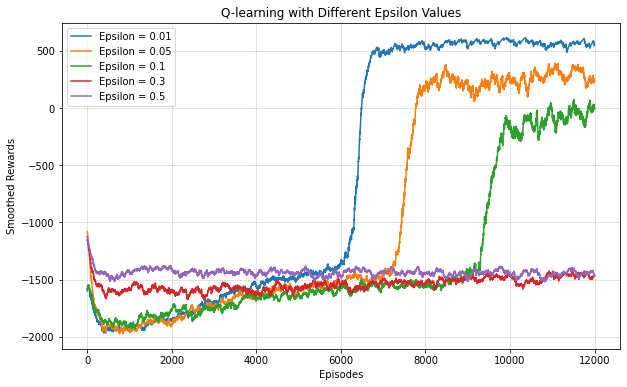

In [ ]:
def smooth_rewards(rewards, weight=0.99):
    last = rewards[0]
    smoothed = []
    for v in rewards:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

env = CliffBoxGridWorld()
epsilon_values = [0.01, 0.05, 0.1, 0.3, 0.5]
num_episodes = 12000

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    agent = QAgent(env, epsilon=epsilon, alpha=0.1, gamma=0.99, num_episodes=num_episodes)
    start_time = time.time()
    rewards = agent.learn()
    elapsed_time = time.time() - start_time
    print(f"Elapsed time for epsilon {epsilon}: {elapsed_time:.2f} seconds")
    smoothed_rewards_list = smooth_rewards(rewards)
    plt.plot(smoothed_rewards_list, label=f"Epsilon = {epsilon}")

plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.title("Q-learning with Different Epsilon Values")
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

It can be observed from the plot above that q-learning with epsilon 0.01 has the highest performance. However this is at a trade-off at the elapsed time to train the agent. For the rest of the assignment, we will be using the q-learning agent with epsilon of 0.01, as it is the parameter whereby the result converge to the most optimal reward of 642.

Training Q-learning Agent with the most optimum parameter (epsilon=0.01)


In [ ]:
env = CliffBoxGridWorld()
agent = QAgent(env, epsilon=0.01, alpha=0.1, gamma=0.99, num_episodes=12000)
rewards = agent.learn()

# Q-Learning Episodes vs Episode Rewards Curve

It can be observed from the plot below that the q-learning agent converge nicely at the maximum reward of 642 by about episode 7000

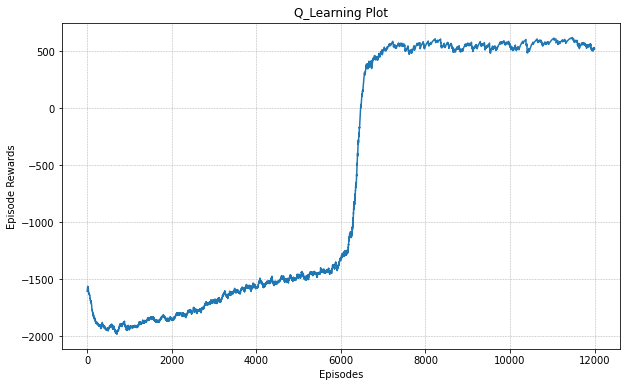

In [ ]:
# Smooth plot
weight = 0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(smoothed)
plt.xlabel("Episodes")
plt.ylabel("Episode Rewards")
plt.title('Q_Learning Plot')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Q-learning V_table Visualization

Finding the 'V' for the agent

In [ ]:
v_table = {}
for state_, actions_ in agent.q_table.items():
    v_table['('+','.join(map(str, state_))+')'] = list(actions_.values())
df = pd.DataFrame.from_dict(v_table).transpose()
df['state'] = list(df.index)
df['Agent_Position'] = df['state'].apply(lambda x:x[1:5].rstrip(','))
df_group = df.groupby('Agent_Position')[[0, 1, 2, 3]].mean()

df_group = df.groupby('Agent_Position')[[0, 1, 2, 3]].mean().reset_index()
df_group['V'] = df_group[[0, 1, 2, 3]].mean(axis=1)
df_group[['agent_x', 'agent_y']] = df_group['Agent_Position'].str.split(',', expand=True)

# showing the data frame in terms of x and y coordinate of agent, and 'V'
df_group = df_group[['agent_x', 'agent_y', 'V']]
df_group

,agent_x,agent_y,V
0,0,0,-38.984695
1,0,1,-38.942938
2,0,10,-29.348510
3,0,11,-25.972059
4,0,12,-20.860093
...,...,...,...
79,5,5,-36.902751
80,5,6,-37.585246
81,5,7,-36.618458
82,5,8,-33.089563


**Presentation of V_table in the template of the Cliff Box Grid World**

It can be observed from the grid view of the 'V' that the obstacles 'V' are all zero, which by intuition make sense.

In [ ]:
# create a 6x14 array of NaN values
grid = np.empty((6, 14))
grid[:] = np.nan

# fill in the grid with the V values from the dataframe
for _, row in df_group.iterrows():
    x = int(row['agent_x'])
    y = int(row['agent_y'])
    grid[x, y] = round(row['V'], 2)

# create a dataframe from the grid
grid_df = pd.DataFrame(grid, columns=range(14), index=range(6))

# set format for V values
grid_df = grid_df.style.format("{:.2f}")

# add borders and show row/column indices
grid_df = grid_df.set_table_styles([
    {"selector": "th", "props": [("border", "1px solid #ccc"), ("text-align", "center")]},
    {"selector": "td", "props": [("border", "1px solid #ccc"), ("text-align", "center")]},
    {"selector": "th.row_heading", "props": [("background-color", "transparent"),]}
])

# display formatted grid of v_table
print('V_table Visualization')
display(grid_df)

V_table Visualization


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-38.98,-38.94,-38.40,-37.13,-33.09,-43.32,0.00,0.00,-40.29,-30.23,-29.35,-25.97,-20.86,-16.29
1,-32.91,-31.63,-33.93,-44.48,-38.15,-43.49,0.00,0.00,-37.79,-24.23,-24.06,-22.71,-31.22,-18.16
2,-35.05,-33.01,-43.51,0.00,-44.00,-44.53,0.00,0.00,-40.96,-26.52,-26.01,-42.38,0.00,-30.39
3,-37.60,-32.89,-44.95,0.00,-45.12,-42.05,0.00,-48.21,-34.37,-28.63,-37.91,0.00,0.00,-33.42
4,-39.79,-33.45,-43.54,0.00,-42.63,-31.42,-43.14,-31.26,-29.58,-29.41,-37.50,0.00,0.00,-32.12
5,-36.17,-33.93,-45.67,0.00,-45.34,-36.90,-37.59,-36.62,-33.09,-28.15,-37.48,0.00,0.00,-31.10


# Q-learning Policy Visualization

Below is the presentation of policy of the agent following the action sequence taken for the maximum reward, which is 642.

As observed shown below, the agent is travelling correctly with the action sequence = [4, 1, 1, 1, 3, 1, 4, 4, 4, 4, 1, 4, 2, 2, 2, 3, 2, 4, 4, 4, 4, 4, 2, 4, 1, 1, 1, 3, 1, 4, 4, 4, 1, 4, 2, 2, 2]

In [ ]:
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []
step = 0

while not done:
    action = agent.max_action_seq[step]
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, action taken: {agent.action_seq[action]}, reward: {reward}')
    env.print_world()
    step += 1

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), action taken: 3, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 2, state: (4, 1, 3, 1), action taken: 1, reward

# Bonus Question: Upper Confidence Boundary (UCB)

UCB stands for Upper Confidence Bound, an algorithm used in the multi-armed bandit problem. The multi-armed bandit problem is a classic reinforcement learning problem that models the trade-off between exploration and exploitation. The problem involves a gambler who has to decide which arm of a K-slot machine to pull to maximize the total reward, with each arm providing a reward from an unknown probability distribution.

The UCB algorithm addresses this exploration-exploitation dilemma by choosing the action that has the highest upper confidence bound on its expected reward. This means that the algorithm not only considers the average reward of each action but also takes into account the uncertainty associated with the reward estimation.

The UCB1 algorithm, a popular variant of UCB, is defined as follows:

UCB1(a) = X_a + sqrt((2 * ln(N)) / n_a)

where:
*   a is an action (arm)
*   X_a is the average reward of action a so far
*   N is the total number of times any action has been taken
*   n_a is the number of times action a has been taken
*   ln is the natural logarithm
*   sqrt denotes the square root



By choosing the action with the highest UCB1 value, the algorithm balances the trade-off between selecting actions with high average rewards (exploitation) and actions that have been tried less often (exploration), as their true reward might not be well estimated yet.

Below is an example of a UCB agent for the Cliff Box Pushing Grid environment.

In [ ]:
class UCBAgent:
    def __init__(self, env, num_episodes, c=1.0, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        self.n_table = dict() # Store count of state-action pairs
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}
                        self.n_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.c = c
        self.alpha = alpha
        self.gamma = gamma
        self.action_seq = [] # Initialize empty action sequence list
        self.total_action_seq = [] # Initialize empty action sequence list
        self.max_agent_seq = []

    def act(self, state):
        """Returns the (UCB) optimal action from Q-Value table."""
        n_state = sum(self.n_table[state].values())
        ucb_values = {}
        for action in self.action_space:
            n_sa = self.n_table[state][action]
            q_sa = self.q_table[state][action]
            ucb_values[action] = q_sa + self.c * np.sqrt(np.log(n_state) / (n_sa + 1e-6))
        action = max(ucb_values, key=ucb_values.get)
        return action

    def learn(self):
        """Runs Q-learning algorithm to learn optimal policy."""
        rewards_per_episode = []
        start_time = time.time()

        for episode in range(self.num_episodes):
            # Initialize variables for storing state and action sequences
            action_seq = []
            state = self.env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                # Update Q-Table using Q-Learning algorithm
                old_qvalue = self.q_table[state][action]
                next_max = max(self.q_table[next_state].values())
                new_qvalue = (1 - self.alpha) * old_qvalue + self.alpha * (reward + self.gamma * next_max)
                self.q_table[state][action] = new_qvalue

                # Update count of state-action pairs
                self.n_table[state][action] += 1

                # Update total reward and current state
                total_reward += reward
                state = next_state
                action_seq.append(action)
                self.action_seq = action_seq # Append action to the action sequence list

            self.total_action_seq.append(action_seq)
            rewards_per_episode.append(total_reward)
            max_reward = max(rewards_per_episode)
            index_max_reward = rewards_per_episode.index(max_reward)
            self.max_action_seq = self.total_action_seq[index_max_reward]

        elapsed_time = time.time() - start_time
        elapsed_time_formatted = str(round(elapsed_time, 2)) + "seconds"
        #print(rewards_per_episode)
        #print('Elapsed time:', elapsed_time_formatted)
        #print('Maximum reward =', max_reward)
        #print('Episode of maximum reward achieved =', index_max_reward)
        #print('Action sequence of maximum reward =', self.max_action_seq)
        return rewards_per_episode

<ipython-input-10-1f78bc82289a>:31: RuntimeWarning: divide by zero encountered in log
  ucb_values[action] = q_sa + self.c * np.sqrt(np.log(n_state) / (n_sa + 1e-6))
<ipython-input-10-1f78bc82289a>:31: RuntimeWarning: invalid value encountered in sqrt
  ucb_values[action] = q_sa + self.c * np.sqrt(np.log(n_state) / (n_sa + 1e-6))


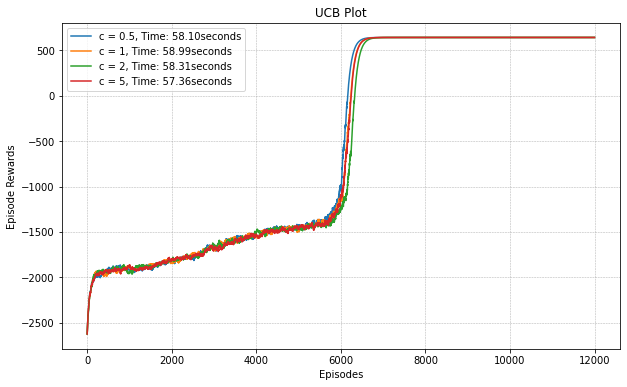

In [ ]:
env = CliffBoxGridWorld()
num_episodes = 12000
conf_levels = [0.5, 1, 2, 5] # Compare performance between different confidence levels

# Train agents for each confidence level
agents = []
for c in conf_levels:
    agent = UCBAgent(env, c=c, num_episodes=num_episodes)
    start_time = time.time()
    rewards = agent.learn()
    elapsed_time = time.time() - start_time
    agents.append((agent, rewards, elapsed_time))

# Smooth and plot learning curves for each agent
plt.figure(figsize=(10, 6))
for i, (agent, rewards, elapsed_time) in enumerate(agents):
    # Smooth plot
    weight = 0.99
    last = rewards[0]
    smoothed = []
    for v in rewards:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val

    # Plot learning curve
    plt.plot(smoothed, label=f"c = {conf_levels[i]}, Time: {elapsed_time:.2f}seconds")

plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel("Episodes")
plt.ylabel("Episode Rewards")
plt.title('UCB Plot')
plt.legend()
plt.show()

It can be observed from the plot above that confidence level has very little effect on the performance of UCB agent in this Cliff Box Grid World environment.

For the rest of the experiment, we will use c=0.5 for the experiment as it converge slightly faster than the rest of the confidence levels.

# Comparing Q-agent with UCB-Agent performance on Cliff Box Grid World Environment

Upper Confidence Bound (UCB) is an exploration strategy used in Multi-Armed Bandit problems, while Q-learning is a model-free reinforcement learning algorithm used for learning optimal policies in Markov Decision Processes (MDP). Comparing these two algorithms directly may not be appropriate, as they address different types of problems. However, we can still discuss scenarios where UCB-like exploration may be more beneficial than the default exploration strategy used in Q-learning, such as ε-greedy.

UCB performs better than Q-learning with ε-greedy exploration in environments where:

1.   Exploration vs. Exploitation trade-off is crucial: UCB balances
exploration and exploitation by considering the uncertainty in the action-value estimates. It chooses actions that have not only high potential rewards but also high uncertainty. In contrast, ε-greedy exploration in Q-learning selects random actions with a fixed probability ε, which might lead to inefficient exploration

2.   Non-stationary environments: UCB's exploration strategy can adapt better to changing environments because it is more sensitive to the uncertainty in action-value estimates. Q-learning with ε-greedy exploration may struggle to adapt quickly if the environment's dynamics change significantly


3.   Large action spaces: In problems with a large number of actions, UCB's exploration strategy can be more efficient than ε-greedy, as it focuses on actions with high uncertainty rather than exploring uniformly at random.




<ipython-input-10-1f78bc82289a>:31: RuntimeWarning: divide by zero encountered in log
  ucb_values[action] = q_sa + self.c * np.sqrt(np.log(n_state) / (n_sa + 1e-6))
<ipython-input-10-1f78bc82289a>:31: RuntimeWarning: invalid value encountered in sqrt
  ucb_values[action] = q_sa + self.c * np.sqrt(np.log(n_state) / (n_sa + 1e-6))


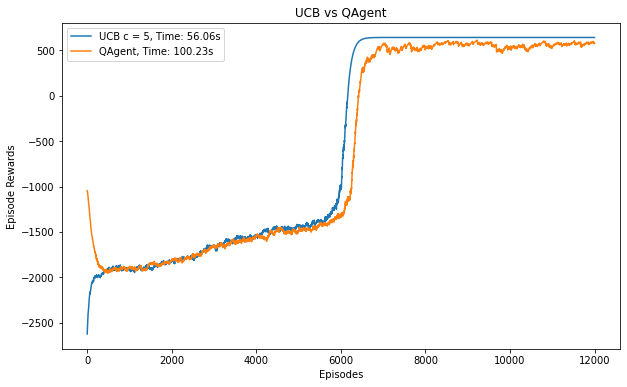

In [ ]:
env = CliffBoxGridWorld()

# Train UCB agent
agent = UCBAgent(env, c=0.5, num_episodes=num_episodes)
ucb_start_time = time.time()
ucb_rewards = agent.learn()
ucb_elapsed_time = time.time() - ucb_start_time

# Train QAgent
q_agent = QAgent(env, epsilon=0.01, alpha=0.1, gamma=0.99, num_episodes=num_episodes)
q_start_time = time.time()
q_rewards = q_agent.learn()
q_elapsed_time = time.time() - q_start_time

# Smooth and plot learning curves for both agents
plt.figure(figsize=(10, 6))

# Smooth and plot UCB agent learning curve
weight = 0.99
last = ucb_rewards[0]
smoothed = []
for v in ucb_rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val
plt.plot(smoothed, label=f"UCB c = {c}, Time: {ucb_elapsed_time:.2f}s")

# Smooth and plot QAgent learning curve
weight = 0.99
last = q_rewards[0]
smoothed = []
for v in q_rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val
plt.plot(smoothed, label=f"QAgent, Time: {q_elapsed_time:.2f}s")

plt.xlabel("Episodes")
plt.ylabel("Episode Rewards")
plt.title('UCB vs QAgent')
plt.legend()
plt.show()

It can be observed from the above plot that both Q-learning and UCB-agent have slight difference in performance for the environment of Cliff Box Grid World. This is a comparison of both Q-learning agent running on the most optimum epsilon (epsilon=0.01) and also UCB agent running on the most optimum confidence (c=1).


The main differences are:

*   First of all, UCB agent elapsed time is much faster at 56.05s, compared to Q-learning agent of 100.23s

*   Secondly, Q-learning agent converge at a slightly later episode than UCB agent

*   Thirdly, the performance of UCB agent is much more stable once it converges, as compared to Q-learning agent




